## After Preprocessing, taking those reviews that had length > 3. 

In [1]:
## imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os
root = os.path.expanduser('~')

company_index='5'
company_name='Amazon'
# img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/'\
# +f'{company_index}_{company_name}'
# img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/LDA_vis'
# img_flag = False

# if not os.path.exists(img_path):
#     os.makedirs(img_path)

In [2]:
## making dataset

def get_px_data(company_index=5, company_name='Amazon',
                uni=True, bi=True, tri=True, procon = 'pros'):
    if procon == 'pros':
        data_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/data/companies/'+\
                    f'{company_index}_{company_name}'+'/output_data/px_data4/pros.csv'
    elif procon == 'cons':
        data_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/data/companies/'+\
                    f'{company_index}_{company_name}'+'/output_data/px_data4/cons.csv'
    else: 
        data_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/data/companies/'+\
                    f'{company_index}_{company_name}'+'/output_data/px_data_reviews1/reviews.csv'
    df = pd.read_csv(data_path)
#     print(df.head())
    df_data = pd.DataFrame()
#     df_data['Company_Index'] = company_index
    
    df_data['Ratings'] = df['Ratings']
    df_data['Job_Status'] = df['Job_Status']
    df_data['Reviewed_Year'] = df['Reviewed_Year'].astype("int")
    df_data['Review_Text'] = df['Review_Text']
    
    
    if uni and bi and tri:
        df_data['Px_Texts'] = df['Unigrams'].fillna('') + ' ' +\
        df['Bigrams'].fillna('') + ' ' + df['Trigrams'].fillna('')
    elif uni:
        df_data['Px_Texts'] = df['Unigrams'].dropna()
    elif bi:
        df_data['Px_Texts'] = df['Bigrams'].dropna()
    elif tri:
        df_data['Px_Texts'] = df['Trigrams'].dropna()
    df_data['Tknz_Texts'] = df_data['Px_Texts'].str.split()
    df_data['Doc_Length'] = df_data['Tknz_Texts'].str.len()
    
    df_data['Work_Life'] = df['Work_Life']
    df_data['Benefits'] = df['Benefits']
    df_data['Job_Advancement'] = df['Job_Advancement']
    df_data['Management'] = df['Management']
    df_data['Culture'] = df['Culture']
#     df_data['Pro_Con'] = procon
    df_data['Company_Index'] = company_index
    df_data['Company_Name'] = (company_name)
    df_data = df_data[df_data.Doc_Length > 3]
    return df_data

# display(get_px_data().head())
# display(get_px_data().shape[0]+get_px_data(procon='cons').shape[0])
get_px_data(procon='pros').head()

,Ratings,Job_Status,Reviewed_Year,Review_Text,Px_Texts,Tknz_Texts,Doc_Length,Work_Life,Benefits,Job_Advancement,Management,Culture,Company_Index,Company_Name
0,5.0,0,2019,"Free drinks, paid time, overtime",drink free overtim paid time free_drink paid_t...,"[drink, free, overtim, paid, time, free_drink,...",8,5.0,5.0,3.0,5.0,5.0,5,Amazon
1,5.0,0,2019,"On your own, flexible, can keep job even worki...",flexibl month time flexibl_time,"[flexibl, month, time, flexibl_time]",4,4.0,2.0,1.0,1.0,3.0,5,Amazon
5,3.0,0,2019,"Amazing health benefits, Ot, prizes during cer...",amaz benefit health ot prize time health_benefit,"[amaz, benefit, health, ot, prize, time, healt...",7,2.0,4.0,2.0,1.0,1.0,5,Amazon
6,4.0,0,2019,"Benefits, paid time off/ vacation (full time)",benefit paid time vacat benefit_paid paid_time...,"[benefit, paid, time, vacat, benefit_paid, pai...",11,4.0,5.0,2.0,2.0,3.0,5,Amazon
8,3.0,0,2019,Main break room was awesome with free arcade g...,arcad awesom break free game main,"[arcad, awesom, break, free, game, main]",6,3.0,4.0,4.0,2.0,2.0,5,Amazon


## Use this if you need pro cons sampled

In [3]:
def merge_data(company_list=[5], uni=False, bi=False, tri=False):
    sentences = []
    df_company_list = pd.read_csv( root + \
            '/Desktop/workspace/indeed/Job-Satisfaction/data/scraper_data/indeed_site50.csv')
    sentences = pd.DataFrame(columns = ['Ratings', 'Job_Status', 'Reviewed_Year', 'Review_Text', 'Px_Texts',
                                        'Tknz_Texts', 'Doc_Length', 'Work_Life', 'Benefits', 'Job_Advancement', 
                                        'Management', 'Culture', 'Company_Index', 'Company_Name'])
    for company_index in company_list:
        company_name = df_company_list.iloc[company_index - 1]['Company_Name']
        px_sents = get_px_data(company_index=company_index, company_name=company_name, 
                        uni=uni, bi=bi, tri=tri, procon='cons')
        if (px_sents.shape[0]) < 1000:
            sentences = pd.concat([sentences, px_sents], ignore_index=True)
        else:
#             sentences = pd.concat([sentences, px_sents.sample(n=1000, random_state=42)],\
#                                   ignore_index=True)
            sentences = pd.concat([sentences, px_sents.sample(n=1000, random_state=6)],\
                                  ignore_index=True)
    return sentences

# sentences = merge_data(company_list=[5],
#                         uni=True, bi=True, tri=True)
sentences = merge_data(company_list=range(1, 51),
                        uni=True, bi=True, tri=True)
# sentences = merge_data(company_list=[5, 6, 7, 8, 9, 10],
#                         uni=True, bi=True, tri=True)
# print(len(sentences))
display(sentences.head())
display(sentences.shape)

sentences.to_csv('~/Desktop/workspace/indeed/Job-Satisfaction/data/prepx/con_doc_sampled_6.csv')

,Ratings,Job_Status,Reviewed_Year,Review_Text,Px_Texts,Tknz_Texts,Doc_Length,Work_Life,Benefits,Job_Advancement,Management,Culture,Company_Index,Company_Name
0,2.0,0,2019,poor management and co workers,co manag poor worker co_worker poor_manag,"[co, manag, poor, worker, co_worker, poor_manag]",6,4.0,4.0,1.0,1.0,3.0,1,Walmart
1,5.0,0,2017,"breaks and lunches might not be time, might ne...",break lunch time break_lunch lunch_time break_...,"[break, lunch, time, break_lunch, lunch_time, ...",6,3.0,5.0,2.0,2.0,3.0,1,Walmart
2,4.0,1,2019,If you're not a favorite noone will notice you...,bad disciplin employe favorit lack notic your,"[bad, disciplin, employe, favorit, lack, notic...",7,5.0,4.0,2.0,4.0,3.0,1,Walmart
3,3.0,0,2016,"poor pay, little hours, and horrible benefits.",benefit horribl hour littl pay poor littl_hour...,"[benefit, horribl, hour, littl, pay, poor, lit...",9,3.0,2.0,2.0,1.0,3.0,1,Walmart
4,1.0,1,2017,"Poor management resulting in low morale, low c...",class custom disrespect low manag moral poor r...,"[class, custom, disrespect, low, manag, moral,...",10,1.0,4.0,3.0,1.0,3.0,1,Walmart


(32988, 14)

In [4]:
# sentences["Tknz_Texts"].count().sort_values(by="ascending")


In [5]:
sentences.groupby('Company_Name')['Review_Text'].count()

Company_Name
AT&T                           1000
Amazon                         1000
AmerisourceBergen               286
Anthem                          723
Apple                          1000
Archer-Daniels-Midland          155
Bank-of-America                1000
Berkshire-Hathaway               35
Boeing                         1000
CVS-Health                     1000
Cardinal-Health                 525
Chevron                         448
Citigroup                      1000
Comcast                        1000
Costco-Wholesale               1000
Dell-Technologies               854
DuPont-de-Nemours               228
Exxonmobil                      343
Fannie-Mae                      143
FedEx                          1000
Ford-Motor-Company              460
Freddie-Mac                     112
General-Electric                601
General-Motors                  622
Google                          313
Home-Depot                     1000
IBM                            1000
Intel          

## Use this if you want all pro con texts

In [4]:
def merge_data(company_list=[5], uni=False, bi=False, tri=False):
    sentences = []
    df_company_list = pd.read_csv( root + \
            '/Desktop/workspace/indeed/Job-Satisfaction/data/scraper_data/indeed_site50.csv')
    sentences = pd.DataFrame(columns = ['Ratings', 'Job_Status', 'Reviewed_Year', 'Review_Text', 'Px_Texts',
                                        'Tknz_Texts', 'Doc_Length', 'Work_Life', 'Benefits', 'Job_Advancement', 
                                        'Management', 'Culture', 'Company_Index', 'Company_Name'])
    for company_index in company_list:
        company_name = df_company_list.iloc[company_index - 1]['Company_Name']
        px_sents = get_px_data(company_index=company_index, company_name=company_name, 
                        uni=uni, bi=bi, tri=tri, procon='pros')
#         if (px_sents.shape[0]) < 1000:
        sentences = pd.concat([sentences, px_sents], ignore_index=True)
#         else:
# #             sentences = pd.concat([sentences, px_sents.sample(n=1000, random_state=42)],\
# #                                   ignore_index=True)
#             sentences = pd.concat([sentences, px_sents.sample(n=1000, random_state=6)],\
#                                   ignore_index=True)
    return sentences

# sentences = merge_data(company_list=[5],
#                         uni=True, bi=True, tri=True)
sentences = merge_data(company_list=range(1, 51),
                        uni=True, bi=True, tri=True)
# sentences = merge_data(company_list=[5, 6, 7, 8, 9, 10],
#                         uni=True, bi=True, tri=True)
# print(len(sentences))
display(sentences.head())
display(sentences.shape)


sentences.to_csv('~/Desktop/workspace/indeed/Job-Satisfaction/data/prepx/pro_doc_all_px4.csv')

,Ratings,Job_Status,Reviewed_Year,Review_Text,Px_Texts,Tknz_Texts,Doc_Length,Work_Life,Benefits,Job_Advancement,Management,Culture,Company_Index,Company_Name
0,1.0,0,2019,The only good part for me was it was close to ...,close hous,"[close, hous]",2,1.0,1.0,1.0,1.0,1.0,1,Walmart
1,5.0,0,2019,Benefits,benefit,[benefit],1,3.0,4.0,3.0,4.0,4.0,1,Walmart
2,1.0,0,2019,Some decent employees work there,decent employe,"[decent, employe]",2,2.0,2.0,1.0,1.0,3.0,1,Walmart
3,2.0,0,2019,free luch on thankgiving sometimes they offer ...,free luch offer sometim time,"[free, luch, offer, sometim, time]",5,3.0,3.0,3.0,1.0,1.0,1,Walmart
4,3.0,0,2019,"15-minute breaks, 60-minute lunches in my stor...",break health insur lunch store vision,"[break, health, insur, lunch, store, vision]",6,3.0,4.0,4.0,2.0,3.0,1,Walmart


(344573, 14)

In [8]:
def merge_data(company_list=[5], uni=False, bi=False, tri=False):
    sentences = []
    df_company_list = pd.read_csv( root + \
            '/Desktop/workspace/indeed/Job-Satisfaction/data/scraper_data/review_site.csv')
    sentences = pd.DataFrame(columns = ['Ratings', 'Job_Status', 'Reviewed_Year', 'Review_Text', 'Px_Texts',
                                        'Tknz_Texts', 'Doc_Length', 'Work_Life', 'Benefits', 'Job_Advancement', 
                                        'Management', 'Culture', 'Company_Index', 'Company_Name','Pro_Con'])
    for company_index in company_list:
        company_name = df_company_list.iloc[company_index - 1]['Company_Name']
        px_sents_pro = get_px_data(company_index=company_index, company_name=company_name, 
                        uni=uni, bi=bi, tri=tri, procon='pros')
        px_sents_con = get_px_data(company_index=company_index, company_name=company_name, 
                        uni=uni, bi=bi, tri=tri, procon='cons')
#         px_sents_pro['Num_Reviews'] = px_sents_pro.shape[0] + px_sents_con.shape[0]
#         px_sents_con['Num_Reviews'] = px_sents_pro.shape[0] + px_sents_con.shape[0]
        sentences = pd.concat([sentences, px_sents_pro], ignore_index=True)
        sentences = pd.concat([sentences, px_sents_con], ignore_index=True)
        
#         if (px_sents.shape[0]) < 1000:
#             sentences = pd.concat([sentences, px_sents], ignore_index=True)
#         else:
#             sentences = pd.concat([sentences, px_sents.sample(n=1000, random_state=42)],\
#                                   ignore_index=True)
    return sentences

# sentences = merge_data(company_list=[5],
#                         uni=True, bi=True, tri=True)
sentences = merge_data(company_list=range(1, 51),
                        uni=True, bi=True, tri=True)
# sentences = merge_data(company_list=[5, 6, 7, 8, 9, 10],
#                         uni=True, bi=True, tri=True)
# print(len(sentences))
display(sentences.head())
display(sentences.shape)


# sentences.to_csv('~/Desktop/workspace/indeed/Job-Satisfaction/data/prepx/con.csv')

FileNotFoundError: [Errno 2] File /Users/bishalsainju/Desktop/workspace/indeed/Job-Satisfaction/data/scraper_data/review_site.csv does not exist: '/Users/bishalsainju/Desktop/workspace/indeed/Job-Satisfaction/data/scraper_data/review_site.csv'

In [9]:
df = sentences.copy()

In [10]:
df[df.Company_Name == 'Amazon'].head()

,Ratings,Job_Status,Reviewed_Year,Review_Text,Px_Texts,Tknz_Texts,Doc_Length,Work_Life,Benefits,Job_Advancement,Management,Culture,Company_Index,Company_Name
2378,3.0,1,2015,short breaks and long hours,break hour short break_hour short_break short_...,"[break, hour, short, break_hour, short_break, ...",6,3.0,4.0,1.0,2.0,2.0,5,Amazon
2379,5.0,1,2017,"Short breaks, long day",break day short break_day short_break short_br...,"[break, day, short, break_day, short_break, sh...",6,5.0,5.0,5.0,5.0,5.0,5,Amazon
2380,5.0,0,2018,security sucks trying to go in and out for you...,break secur suck time tri break_time,"[break, secur, suck, time, tri, break_time]",6,4.0,5.0,5.0,1.0,1.0,5,Amazon
2381,1.0,0,2019,"Always on you about your rates, stressful, & d...",break didnt min rate stress warehous break_5 b...,"[break, didnt, min, rate, stress, warehous, br...",10,1.0,1.0,1.0,1.0,1.0,5,Amazon
2382,5.0,0,2018,"No phones, short break",break phone short short_break,"[break, phone, short, short_break]",4,5.0,5.0,2.0,3.0,5.0,5,Amazon


,Company_Index,Company_Name,Review_Text
0,1,Walmart,1000
27,28,Boeing,1000
28,29,Wells-Fargo,1000
24,25,Bank-of-America,1000
29,30,Citigroup,1000
31,32,Comcast,1000
19,20,Kroger,1000
18,19,Verizon-Communication,1000
17,18,JPMorgan-Chase,1000
35,36,State-Farm-Insurance,1000


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

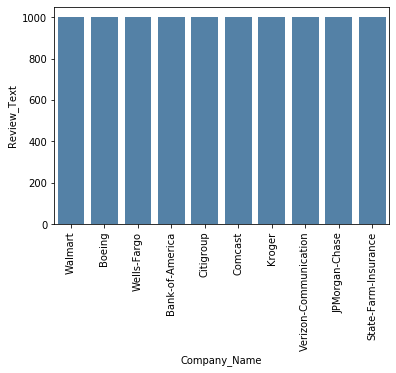

In [11]:
display(df.groupby(['Company_Index', 'Company_Name'])['Review_Text'].count().reset_index().\
        sort_values(by='Review_Text', ascending=False).head(10))
sns.barplot(x='Company_Name', y='Review_Text', 
            data=df.groupby(['Company_Index', 'Company_Name'])['Review_Text'].count().reset_index().\
            sort_values(by='Review_Text', ascending=False).head(10), color='steelblue')
plt.xticks(rotation=90)

,Company_Index,Company_Name,Review_Text
3,4,Berkshire-Hathaway,35
22,23,Phillips-66,103
39,40,Freddie-Mac,112
16,17,Walgreens-Boots-Alliance,120
30,31,Marathon-Petroleum,127
21,22,Fannie-Mae,143
48,49,Archer-Daniels-Midland,155
45,46,United-Technologies,177
23,24,Valero-Energy,214
34,35,DuPont-de-Nemours,228


Text(0.5, 1.0, 'Num Reviews of Companies after Preprocessing (Top 10 Lowest)')

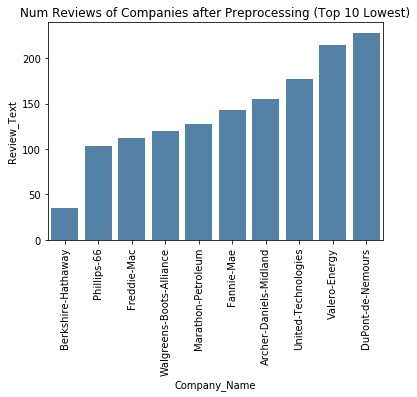

In [12]:
display(df.groupby(['Company_Index', 'Company_Name'])['Review_Text'].count().reset_index().\
        sort_values(by='Review_Text', ascending=True).head(20))
sns.barplot(x='Company_Name', y='Review_Text', 
            data=df.groupby(['Company_Index', 'Company_Name'])['Review_Text'].count().reset_index().\
            sort_values(by='Review_Text', ascending=True).head(10), color='steelblue')
plt.xticks(rotation=90)
plt.title('Num Reviews of Companies after Preprocessing (Top 10 Lowest)')

In [116]:
df_pros = df[df.Pro_Con == 'pros']
display(df_pros.shape)
df_pros.to_csv(root+'/Desktop/workspace/indeed/Job-Satisfaction/data/prepx/pros_doc.csv')

(107954, 15)

In [117]:
df_pros = df[df.Pro_Con == 'cons']
display(df_pros.shape)
df_pros.to_csv(root+'/Desktop/workspace/indeed/Job-Satisfaction/data/prepx/cons_doc.csv')

(107498, 15)